In [1]:
from PIL import Image
from torchvision import transforms
from matplotlib import pyplot as plt
import numpy as np

preprocess = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ]
)

import torch
import torch.nn as nn
from torchvision.models import resnet50

# simple Module to normalize an image
class Normalize(nn.Module):
    def __init__(self, mean, std):
        super(Normalize, self).__init__()
        self.mean = torch.Tensor(mean)
        self.std = torch.Tensor(std)

    def forward(self, x):
        return (x - self.mean.type_as(x)[None, :, None, None]) / self.std.type_as(x)[
            None, :, None, None
        ]


# values are standard normalization for ImageNet images,
# from https://github.com/pytorch/examples/blob/master/imagenet/main.py
norm = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

# load pre-trained ResNet50, and put into evaluation mode (necessary to e.g. turn off batchnorm)
model = resnet50(pretrained=True)
model.eval()

import json

with open("imagenet_class_index.json") as f:
    imagenet_classes = {int(i): x[1] for i, x in json.load(f).items()}

C:\Users\govind.r\Anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
C:\Users\govind.r\Anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


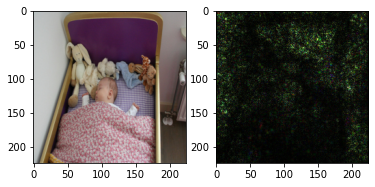

Predictions: ['crib', 'cradle', 'bassinet', 'hamper', 'pencil_box']


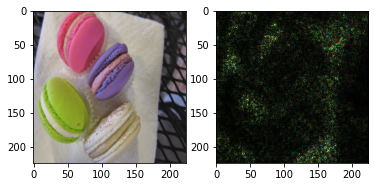

Predictions: ['bath_towel', 'tennis_ball', 'paper_towel', 'rubber_eraser', 'diaper']


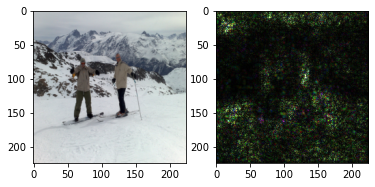

Predictions: ['ski', 'alp', 'shovel', 'dogsled', 'mountain_tent']


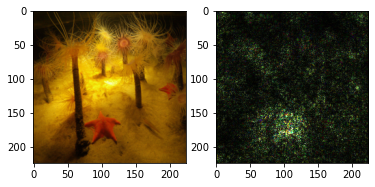

Predictions: ['goldfish', 'axolotl', 'sea_anemone', 'feather_boa', 'starfish']


In [19]:
for filename in ["baby_crib.JPEG", "macaroon.JPEG", "men_ski.JPEG", "starfish.JPEG"]:
    img = Image.open(filename)
    img_tensor = preprocess(img)[None, :, :, :]
    img_tensor.requires_grad = True
    pred = model(norm(img_tensor))
    pred_ix = pred.max(dim=1)[1].item()

    pred[0][pred_ix].backward()

    fig, ax = plt.subplots(nrows=1, ncols=2)
    
    ax[0].imshow(np.transpose(img_tensor.detach().numpy().squeeze(), (1, 2, 0)))
    ax[1].imshow(np.transpose(img_tensor.grad.abs().detach().numpy().clip(0., 1.).squeeze(), (1, 2, 0)))
    plt.show()

    labels = [imagenet_classes[i.item()] for i in pred.topk(5)[1][0]]
    print(f"Predictions: {labels}")